In [13]:
#@title Import libraries.
import numpy as np
from numpy import asarray, save, load
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 23.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.4 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102766 sha256=5128109a01732f8ba36e1e0c098d0c445e2a6c122db53d6e9dd495de4f74f7b6
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy


In [2]:
#@title Connect Google Drive.
from google.colab import drive
drive.mount("/gdrive", force_remount=True)
!cp -r "/gdrive/MyDrive/061923" "/content/"
!cp -r "/gdrive/MyDrive/051423" "/content/"

Mounted at /gdrive


In [75]:
#@title Define utility functions.
def get_test_mse(filepath):
    losses = load(filepath + '_losses.npy')
    preds = load(filepath + '_preds.npy')
    obs = load(filepath + '_testobs.npy')
    mses = load(filepath + '_valmses.npy')
    if preds.ndim != 1:
        print('Test MSE:', ((preds - obs)**2).mean())
        print('Test persistence MSE:', ((obs[:,1:] - obs[:,:-1])**2).mean())
    else:
        print('Test MSE:', ((preds - obs)**2).mean())
        print('Test persistence MSE:', ((obs[1:] - obs[:-1])**2).mean())

def plot_loss_valmse(filepath):
    losses = load(filepath + '_losses.npy')
    preds = load(filepath + '_preds.npy')
    obs = load(filepath + '_testobs.npy')
    mses = load(filepath + '_valmses.npy')
    min_mse = np.min(mses)
    min_mse_index = np.argmin(mses)
    plt.plot(losses, label='Loss: MSE')
    plt.plot(mses, label='Validation: MSE')
    if losses.shape[0] != 400:
        plt.axvline(x=min_mse_index, color='red', linestyle='--')
        plt.text(min_mse_index + 1, (min_mse + losses[min_mse_index])/2, 'Early stopping at Epoch {}'.format(min_mse_index), va='center', ha='left')
    plt.xlabel('Epoch')
    plt.ylabel('')
    plt.legend()
    plt.show()

def plot_blob_ts(filepath):
    losses = load(filepath + '_losses.npy')
    preds = load(filepath + '_preds.npy')
    obs = load(filepath + '_testobs.npy')
    mses = load(filepath + '_valmses.npy')
    if preds.ndim != 1:
        preds = preds[5237]
        obs = obs[5237]
    start_date = np.datetime64('2011-01')
    x = np.arange(start_date, start_date + np.timedelta64(144, 'M'), np.timedelta64(1, 'M'))
    plt.figure(figsize=(12, 6))
    plt.plot(x, preds, marker='o', label='Prediction')
    plt.plot(x, obs, marker='o', label='Observation')
    plt.title('The Blob Index: One Lead Month Predictions by GraphSAGE and Corresponding Observations')
    plt.xlabel('Month')
    plt.ylabel('Blob Index')
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))  # Display labels every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format labels as 'Month Year'
    plt.legend()
    plt.show()
    plt.figure(facecolor = 'white')
    plt.scatter(x=obs, y=preds, label='Blob Index')
    plt.plot(np.linspace(min(obs), max(obs), 100), np.linspace(min(obs), max(obs), 100), color='red', linestyle='-')
    plt.title('The Blob Index: One Lead Month Predictions by GraphSAGE and Corresponding Observations')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')
    plt.legend()
    plt.show()

def plot_ts(filepath):
    losses = load(filepath + '_losses.npy')
    preds = load(filepath + '_preds.npy')
    obs = load(filepath + '_testobs.npy')
    mses = load(filepath + '_valmses.npy')
    if preds.ndim != 1:
        preds = preds[5237]
        obs = obs[5237]
    start_date = np.datetime64('2011-01')
    x = np.arange(start_date, start_date + np.timedelta64(144, 'M'), np.timedelta64(1, 'M'))
    plt.figure(figsize=(12, 6))
    plt.plot(x, preds, marker='o', label='Prediction')
    plt.plot(x, obs, marker='o', label='Observation')
    plt.title('One Lead Month Predictions by GraphSAGE and Corresponding Observations at 42°N, 137.8125°W')
    plt.xlabel('Month')
    plt.ylabel('Normalized Value')
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))  # Display labels every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format labels as 'Month Year'
    #plt.legend()
    plt.show()
    plt.figure(facecolor = 'white')
    plt.scatter(x=obs, y=preds, label='Normalized Value')
    plt.plot(np.linspace(min(obs), max(obs), 100), np.linspace(min(obs), max(obs), 100), color='red', linestyle='-')
    plt.title('One Lead Month Predictions by GraphSAGE and Corresponding Observations')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')
    plt.legend()
    plt.show()

def plot_ts_locs(filepath):
    losses = load(filepath + '_losses.npy')
    preds = load(filepath + '_preds.npy')
    obs = load(filepath + '_testobs.npy')
    mses = load(filepath + '_valmses.npy')
    loc_indices = [5239, 3521, 5305, 2417, 5135, 4313, 2056, 5005, 111, 1852]
    loc_titles = ['A (42.0°N, 132.1875°W) in the Pacific Ocean near Western United States', 'B (0.0°N, 129.375°W) in the Equatorial Pacific Ocean', 'C (44.0°N, 61.875°W) in the Atalantic Ocean near Eastern Canada', 'D (24.0°S, 14.0625°W) in the South Atalantic Ocean', 'E (38.0°N, 8.4375°E) in the Mediterranean Sea', 'F (16.0°N, 64.6875°E) in the Arabian Sea', 'G (32.0°S, 106.875°E) in the Indian Ocean near Western Australia', 'H (34.0°N, 123.75°E) in the East China Sea', 'I (-64.0°S, 137.8125°E) in the Indian Ocean near Antarctica', 'J (36.0°S, 163.125°E) in the Tasman Sea']
    for i in range(len(loc_indices)):
        plt.plot(preds[loc_indices[i]], label='Prediction')
        plt.plot(obs[loc_indices[i]], label='Observation')
        plt.title(loc_titles[i])
        plt.xlabel('Month')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.show()

def plot_scatter_locs(filepath):
    losses = load(filepath + '_losses.npy')
    preds = load(filepath + '_preds.npy')
    obs = load(filepath + '_testobs.npy')
    mses = load(filepath + '_valmses.npy')
    loc_indices = [5239, 3521, 5305, 2417, 5135, 4313, 2056, 5005, 111, 1852]
    loc_titles = ['A (42.0°N, 132.1875°W) in the Pacific Ocean near Western United States', 'B (0.0°N, 129.375°W) in the Equatorial Pacific Ocean', 'C (44.0°N, 61.875°W) in the Atalantic Ocean near Eastern Canada', 'D (24.0°S, 14.0625°W) in the South Atalantic Ocean', 'E (38.0°N, 8.4375°E) in the Mediterranean Sea', 'F (16.0°N, 64.6875°E) in the Arabian Sea', 'G (32.0°S, 106.875°E) in the Indian Ocean near Western Australia', 'H (34.0°N, 123.75°E) in the East China Sea', 'I (-64.0°S, 137.8125°E) in the Indian Ocean near Antarctica', 'J (36.0°S, 163.125°E) in the Tasman Sea']
    for i in range(len(loc_indices)):
        plt.scatter(x=obs[loc_indices[i]], y=preds[loc_indices[i]], label='Normalized Value')
        plt.plot(np.linspace(min(obs[loc_indices[i]]), max(obs[loc_indices[i]]), 100), np.linspace(min(obs[loc_indices[i]]), max(obs[loc_indices[i]]), 100), color='red', linestyle='-')
        plt.title(loc_titles[i])
        plt.xlabel('Observation')
        plt.ylabel('Prediction')
        plt.legend()
        plt.show()

def plot_delta_rmse_map(filepath, coords=coords):
    losses = load(filepath + '_losses.npy')
    preds = load(filepath + '_preds.npy')
    obs = load(filepath + '_testobs.npy')
    mses = load(filepath + '_valmses.npy')
    node_mses = np.mean((preds - obs)**2, axis=1)
    node_persist_mses = np.mean((obs[:,1:] - obs[:,:-1])**2, axis=1)
    df = pd.DataFrame({'lat': coords[:,0], 'lon': coords[:,1], 'persist mse': node_persist_mses, 'mse': node_mses})
    df['persist rmse'] = np.sqrt(df['persist mse'])
    df['rmse'] = np.sqrt(df['mse'])
    df['rmse diff'] = df['persist rmse'] - df['rmse']
    # separate positive and negative rmse values
    positive_rmse = df[df['rmse diff'] > 0]['rmse diff']
    negative_rmse = df[df['rmse diff'] < 0]['rmse diff']
    positive_lats = df[df['rmse diff'] > 0]['lat']
    positive_lons = df[df['rmse diff'] > 0]['lon']
    negative_lats = df[df['rmse diff'] < 0]['lat']
    negative_lons = df[df['rmse diff'] < 0]['lon']
    # create the plot
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_xlim([-180, 180])
    ax.set_ylim([-90, 90])
    ax.scatter(positive_lons, positive_lats, c='red', s=np.abs(positive_rmse) * 225, label='Positive ΔRMSE', edgecolors=None)
    ax.scatter(negative_lons, negative_lats, c='blue', s=np.abs(negative_rmse) * 225, label='Negative ΔRMSE', edgecolors=None)
    ax.legend(loc='lower right', fontsize=15)
    ax.set_title("$ΔRMSE_{GraphSAGE}$($=RMSE_{persistence}-RMSE_{GraphSAGE}$)", fontsize=20)
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor='0.9') # light gray
    ax.add_feature(cfeature.OCEAN, facecolor='w') # white
    # Add latitude and longitude tick labels
    ax.set_xticks(np.arange(min(df['lon']), max(df['lon'])+1, 20), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(min(df['lat']), max(df['lat'])+1, 20), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlabel("Longitude", fontsize=20)
    ax.set_ylabel("Latitude", fontsize=20)
    plt.show()

def plot_node_degree_map(coords=coords, node_degrees=node_degrees, coor=coor):
    df = pd.DataFrame({'lat': coords[:,0], 'lon': coords[:,1]})
    lats = df['lat']
    lons = df['lon']
    # create the plot
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_xlim([-180, 180])
    ax.set_ylim([-90, 90])
    ax.scatter(lons, lats, c='green', s=np.array(node_degrees) / 75, label='Node degree', edgecolors=None)
    ax.legend(loc='lower right', fontsize=15)
    ax.set_title("Node degree$\in$[" + str(min(node_degrees)) + ',' + str(max(node_degrees)) + '], c=' + str(coor), fontsize=20)
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor='0.9') # light gray
    ax.add_feature(cfeature.OCEAN, facecolor='w') # white
    # Add latitude and longitude tick labels
    ax.set_xticks(np.arange(min(df['lon']), max(df['lon'])+1, 20), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(min(df['lat']), max(df['lat'])+1, 20), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlabel("Longitude", fontsize=20)
    ax.set_ylabel("Latitude", fontsize=20)
    plt.show()

def plot_scatter_node_degrees(filepath, node_degrees=node_degrees):
    preds = load(filepath + '_preds.npy')
    obs = load(filepath + '_testobs.npy')
    node_mses = np.mean((preds - obs)**2, axis=1)
    node_rmses = np.sqrt(node_mses)
    node_degrees = np.array(node_degrees)
    plt.scatter(x=node_degrees, y=node_rmses)
    plt.title('RMSE vs. Node Degree')
    plt.xlabel('Node Degree')
    plt.ylabel('RMSE')
    plt.show()

In [48]:
#@title Load data.
coords = load("051423/coords.npy")
node_feats = load("051423/node_feats_sst.npy")
adj_mat = load('051423/adj_mat_0.7.npy')

In [59]:
#@title Plot the node degree map.
coor = 0.7
node_degrees = []
for i in range(len(node_feats)):
  node_degrees.append(len(adj_mat[1][np.where(adj_mat[0] == i)]))

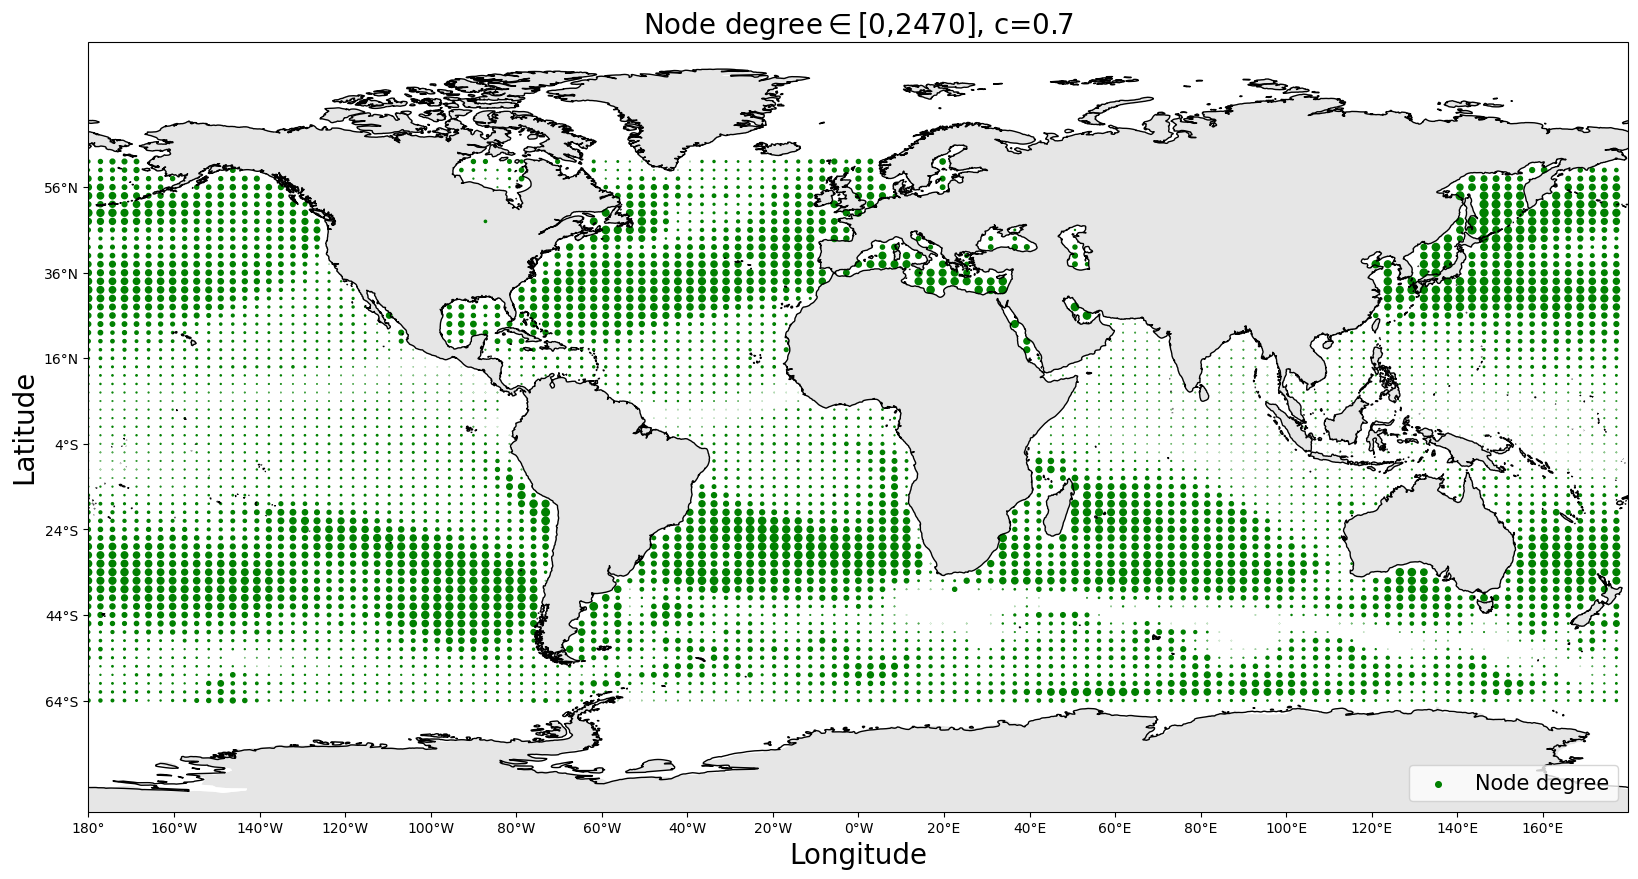

In [61]:
plot_node_degree_map()

Test MSE: 0.00018102334
Test persistence MSE: 0.00095196866


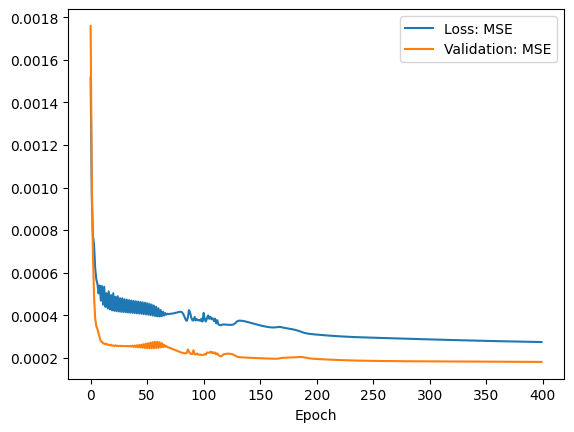

In [72]:
"""
Input: normalized SST graph
Output: normalized SST graph
Model: GraphSAGE 0627
Model Filename: SAGE_0.7_1687694656.466807
"""
filepath = '061923/' + 'SAGE_0.7_1687694656.466807'
get_test_mse(filepath)
plot_loss_valmse(filepath)

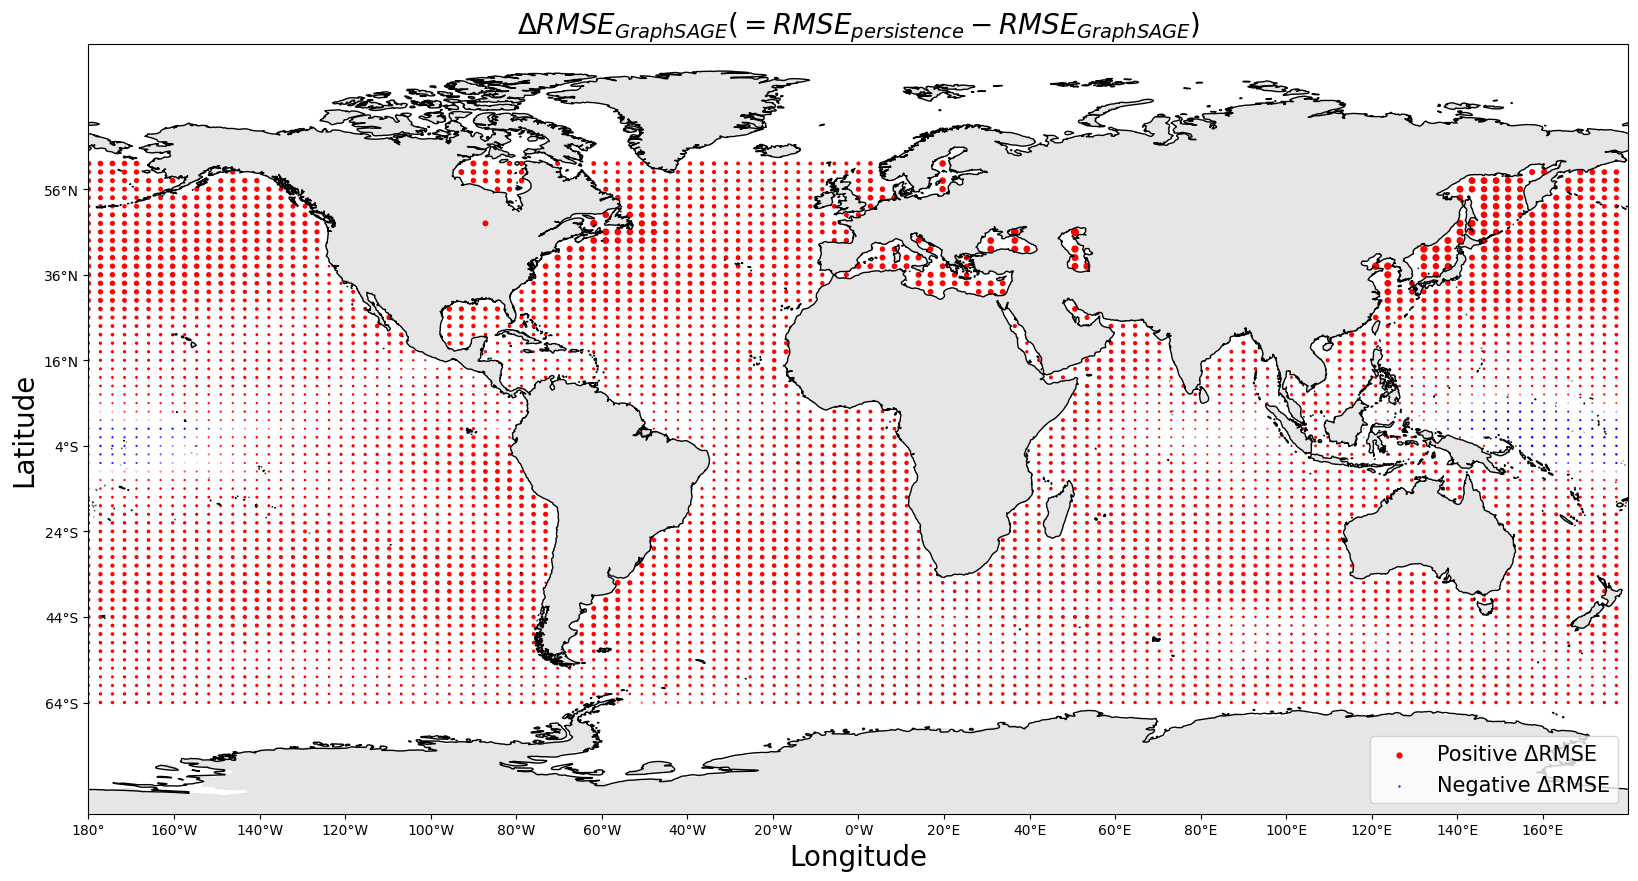

In [77]:
plot_delta_rmse_map(filepath)

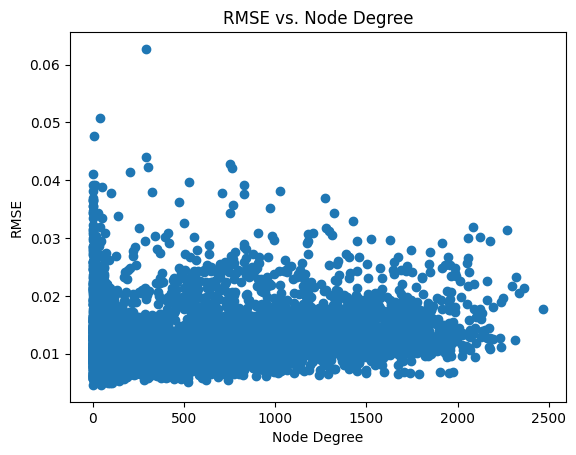

In [81]:
plot_scatter_node_degrees(filepath, node_degrees=node_degrees)

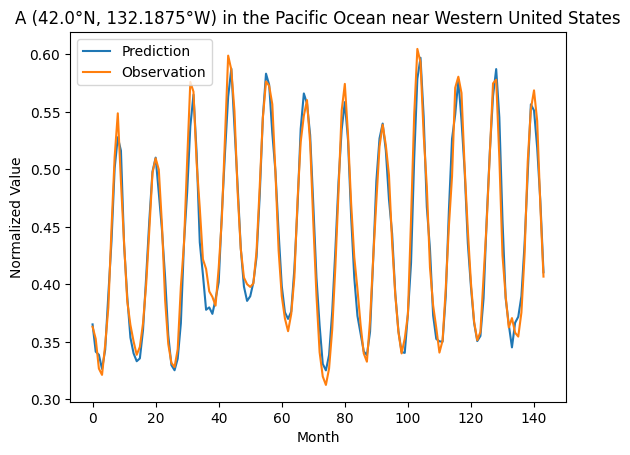

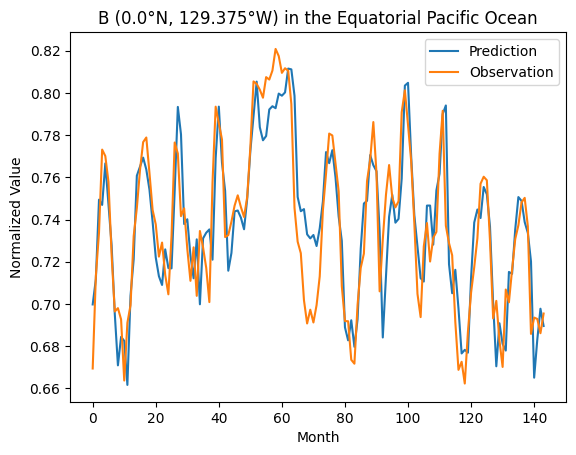

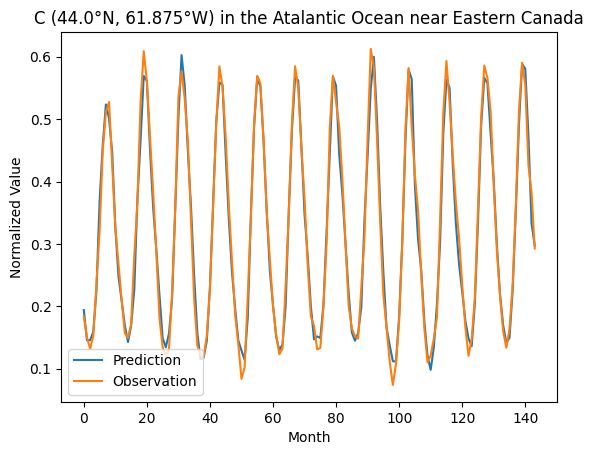

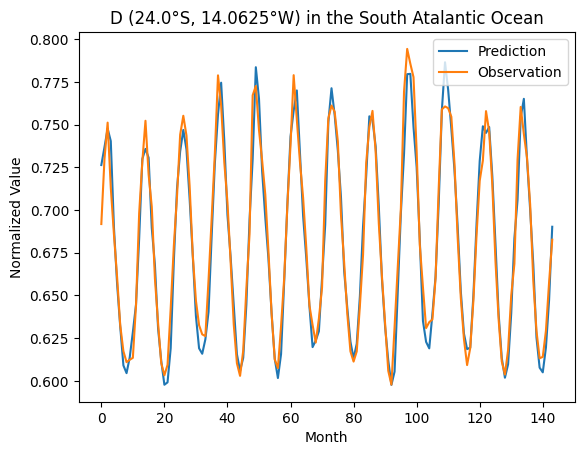

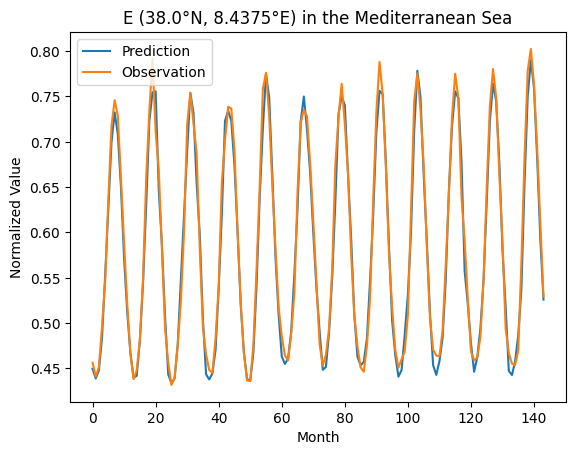

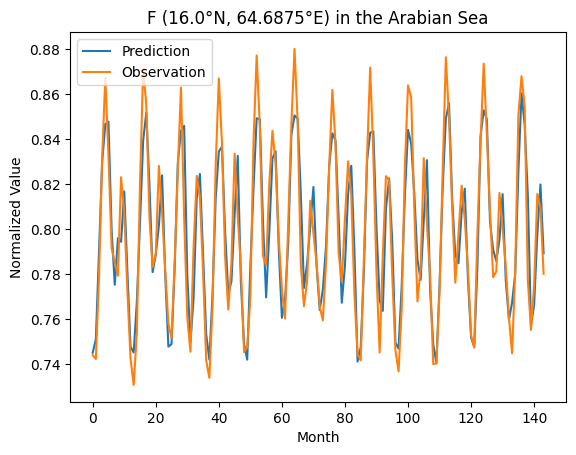

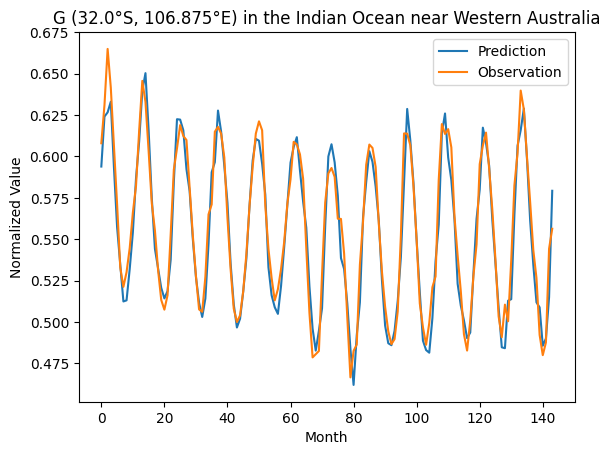

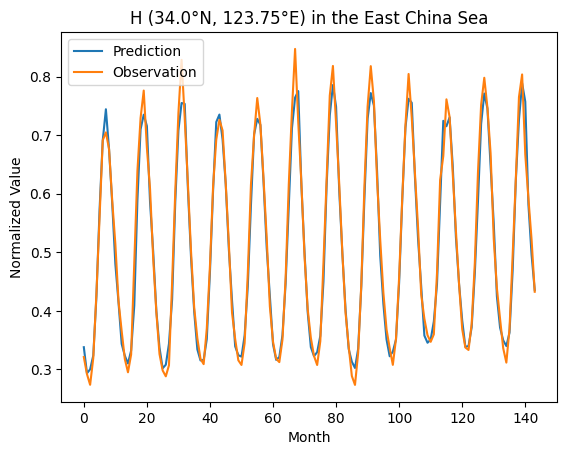

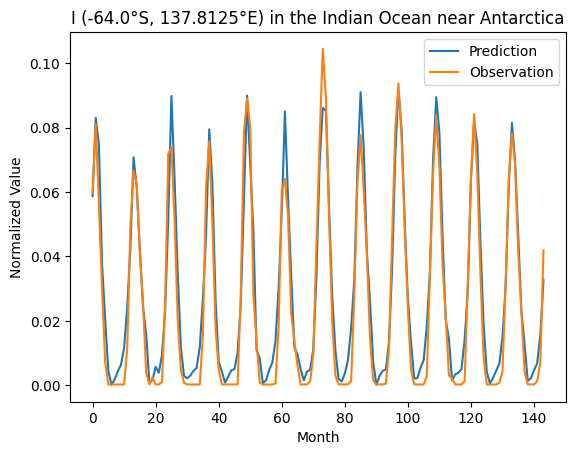

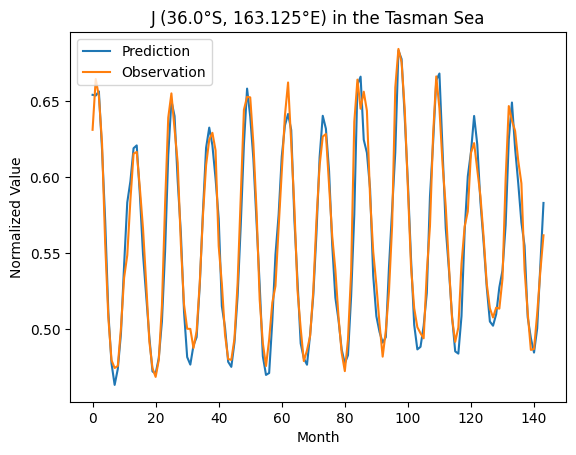

In [79]:
plot_ts_locs(filepath)

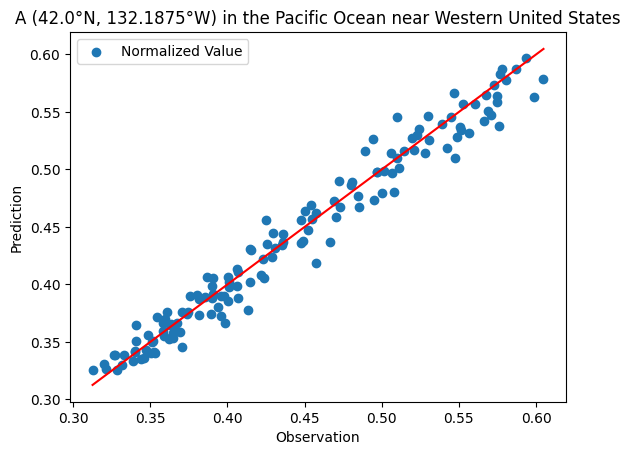

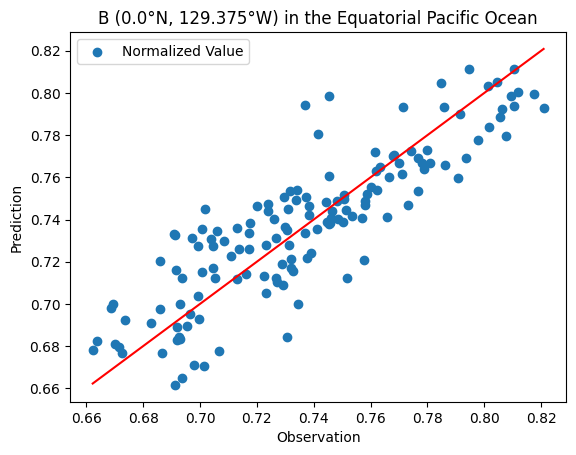

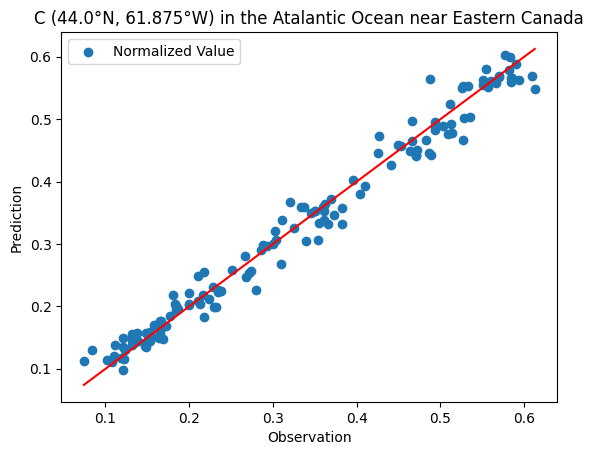

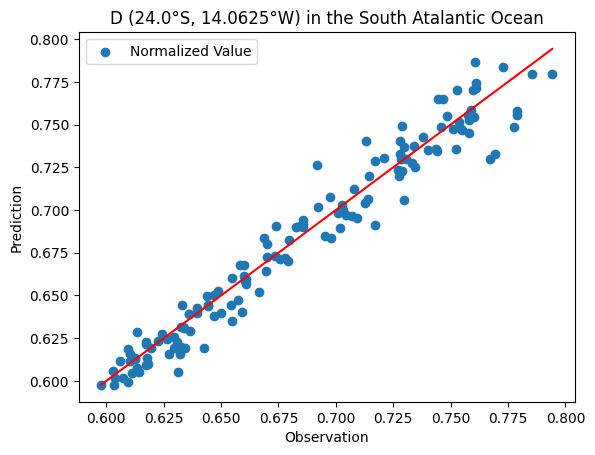

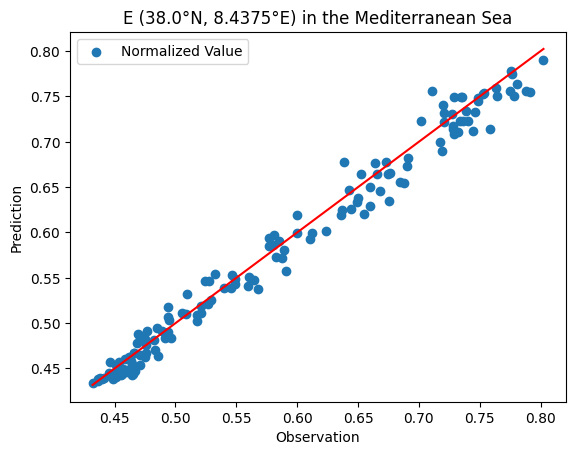

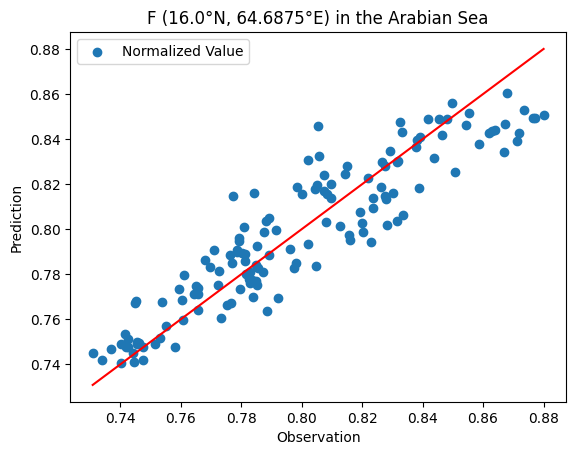

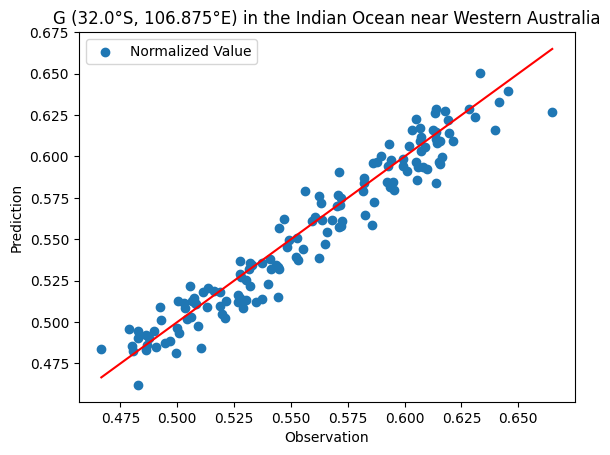

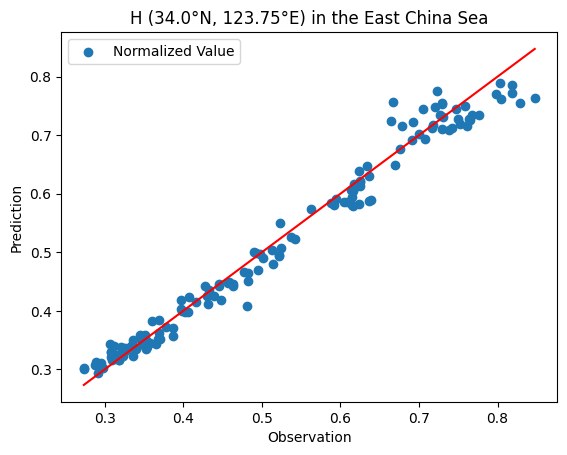

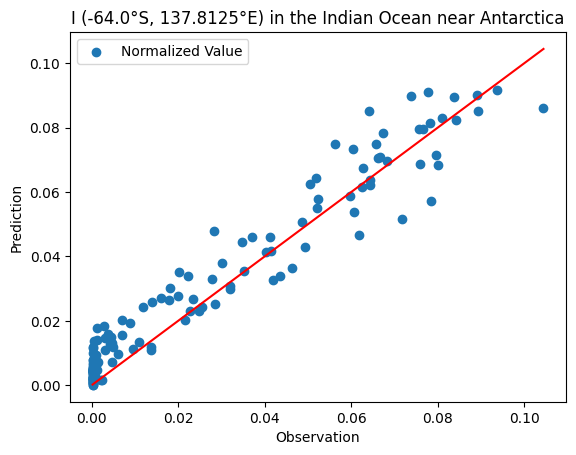

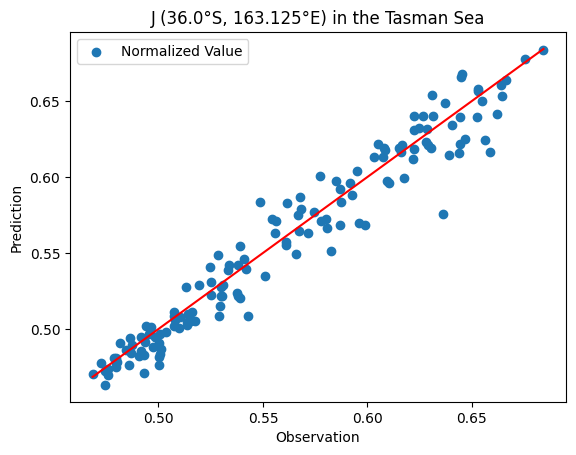

In [80]:
plot_scatter_locs(filepath)

Test MSE: 0.0008430158
Test persistence MSE: 0.0009795361


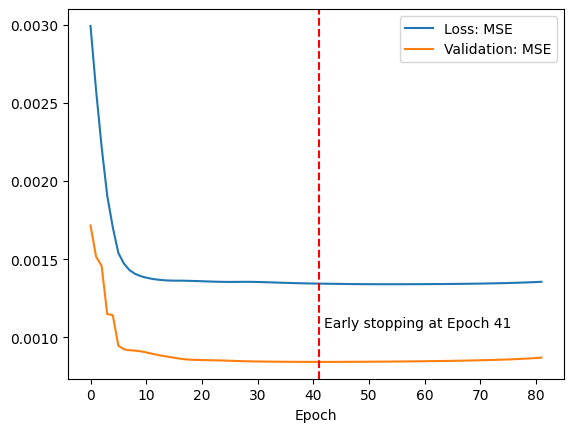

In [82]:
"""
Input: normalized SSTA graph
Output: normalized SSTA graph
Model: GraphSAGE 0623, epoch=400, patience=40
Model Filename: SAGE_0.7_1687459188.371576
"""
filepath = '061923/' + 'SAGE_0.7_1687459188.371576'
get_test_mse(filepath)
plot_loss_valmse(filepath)

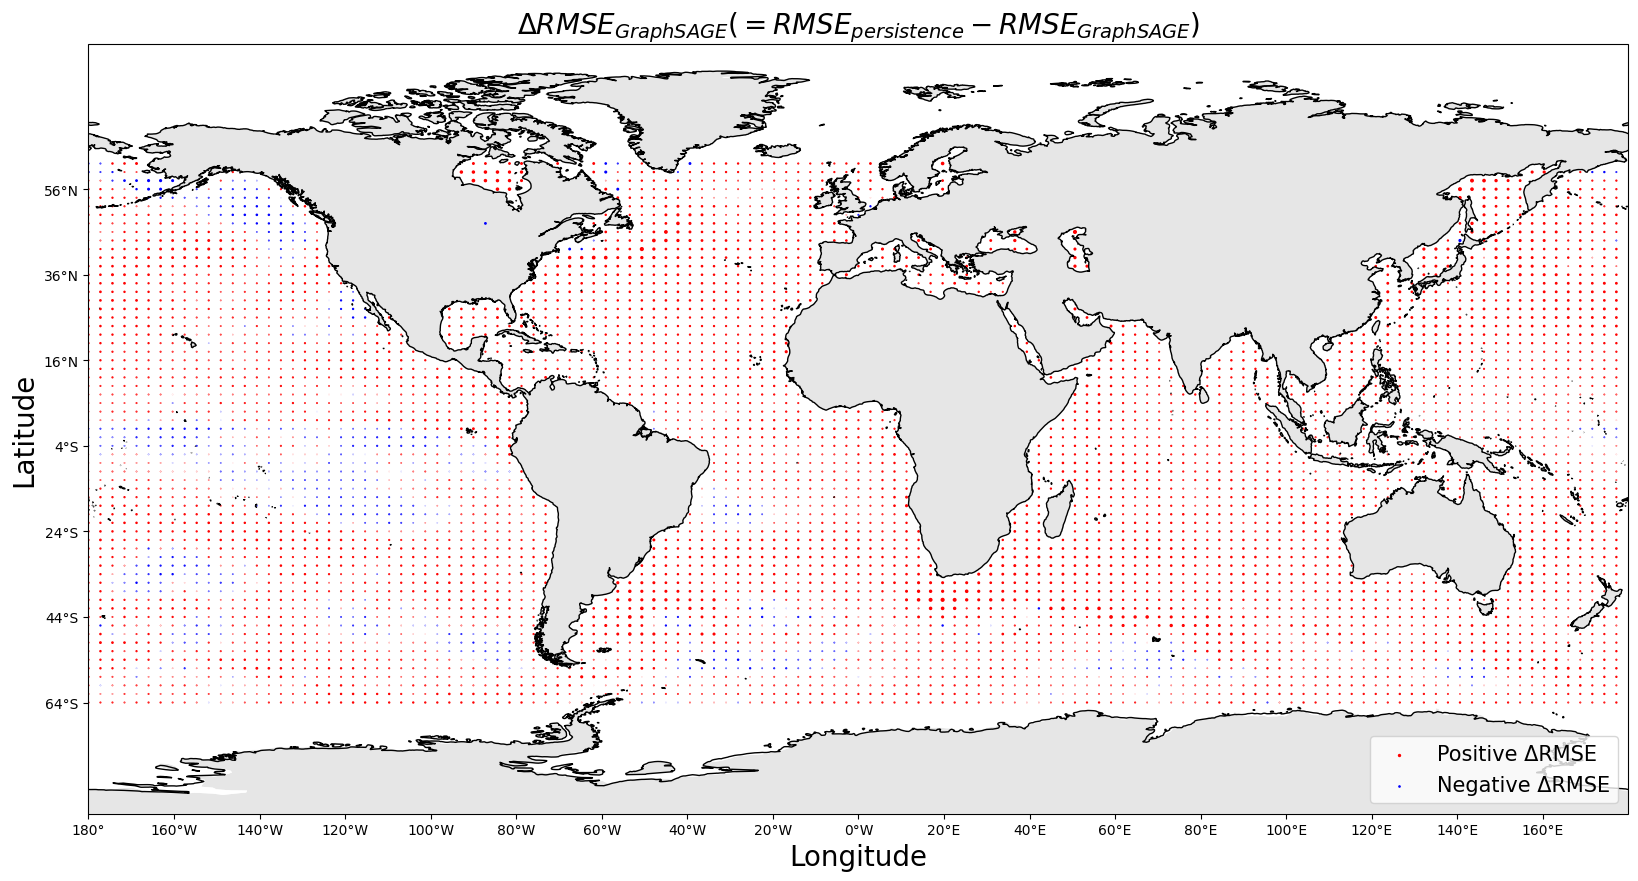

In [83]:
plot_delta_rmse_map(filepath)

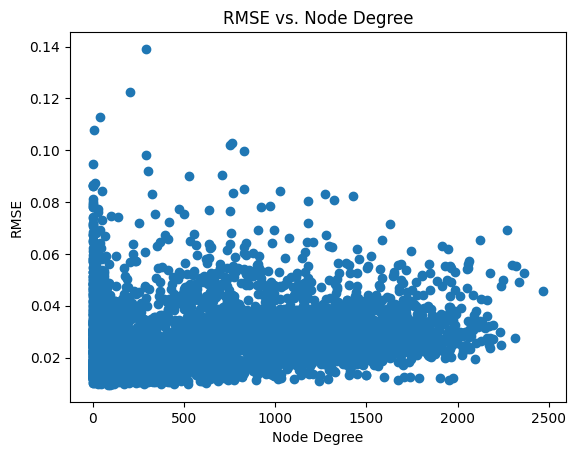

In [84]:
plot_scatter_node_degrees(filepath, node_degrees=node_degrees)

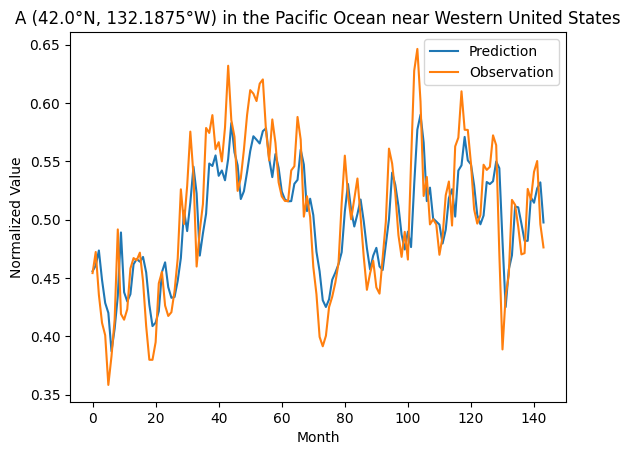

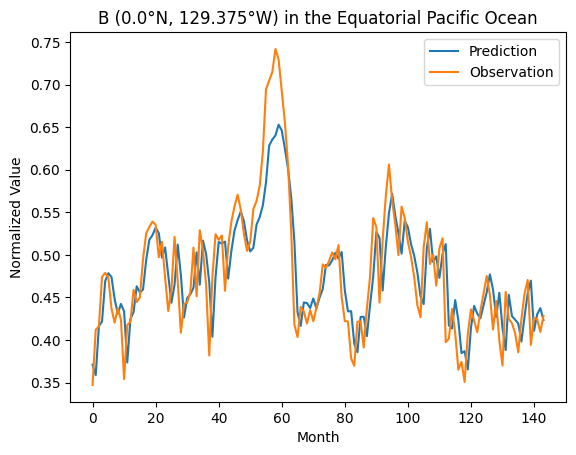

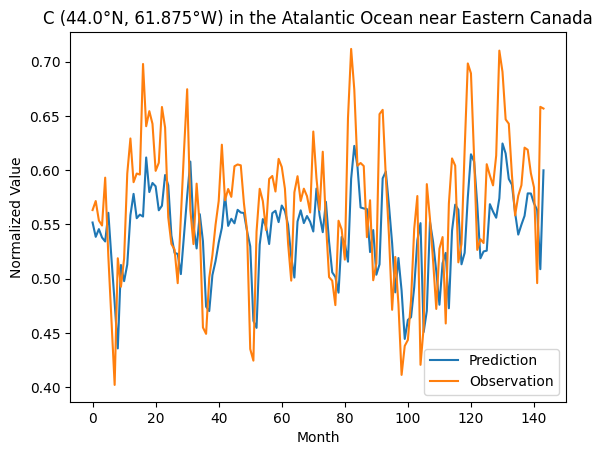

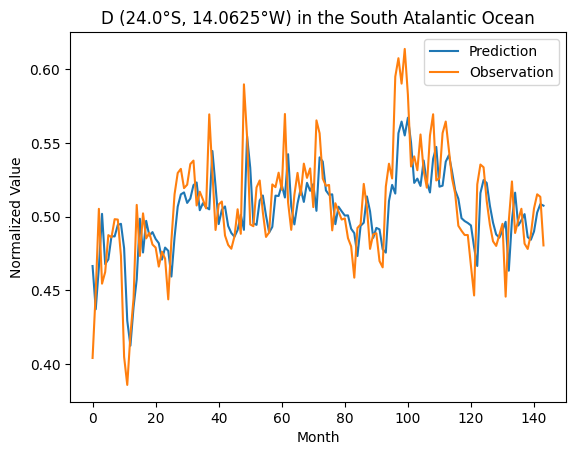

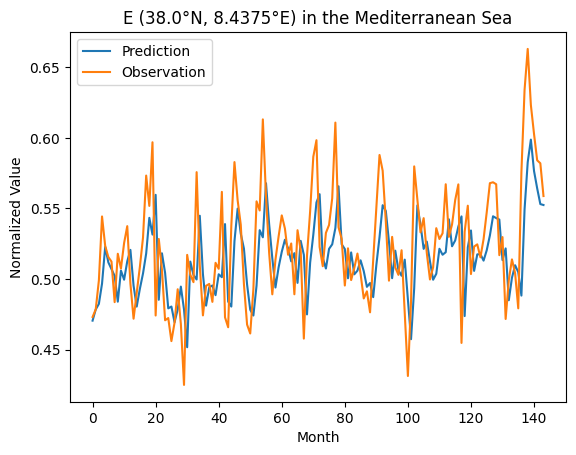

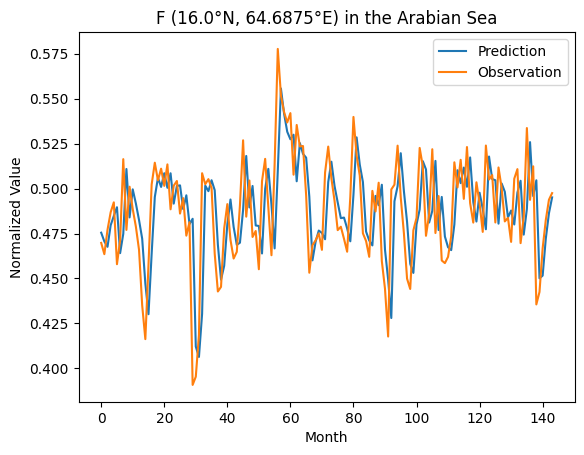

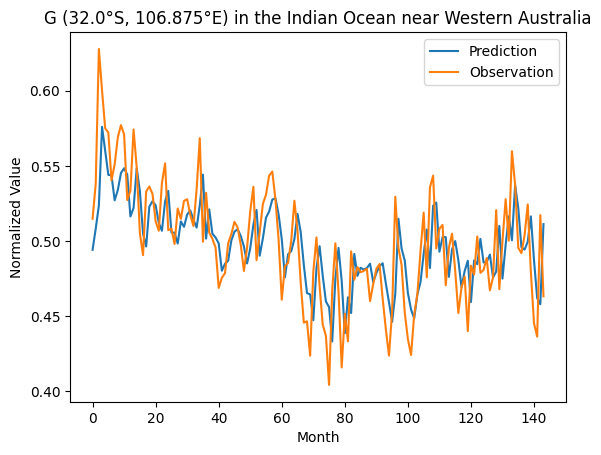

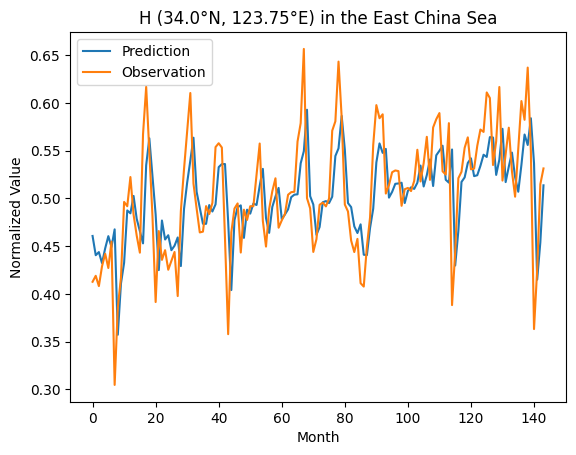

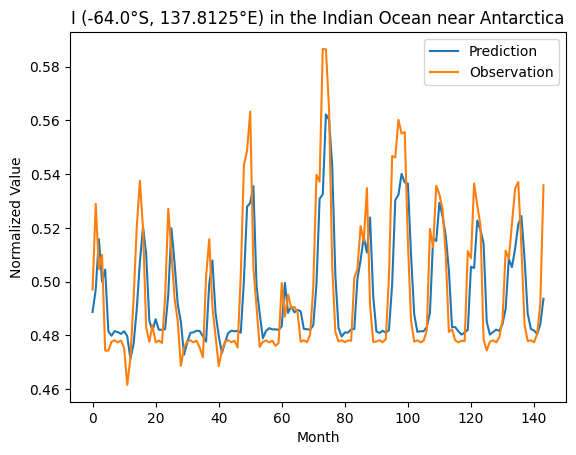

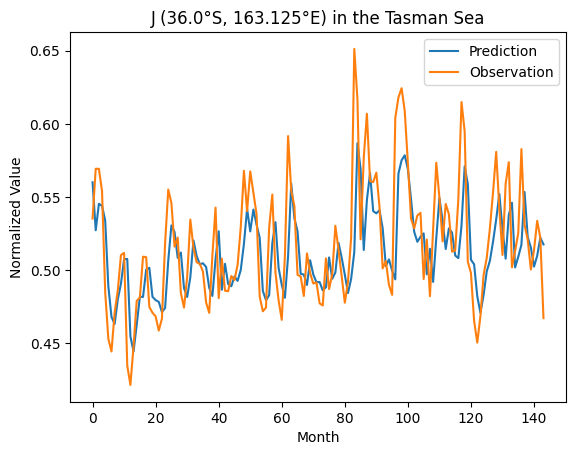

In [85]:
plot_ts_locs(filepath)

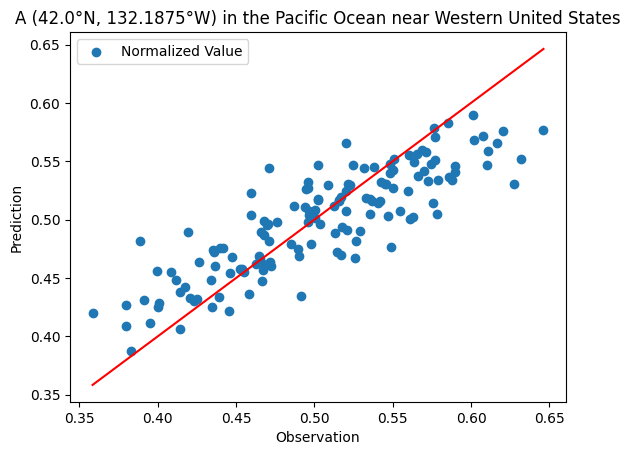

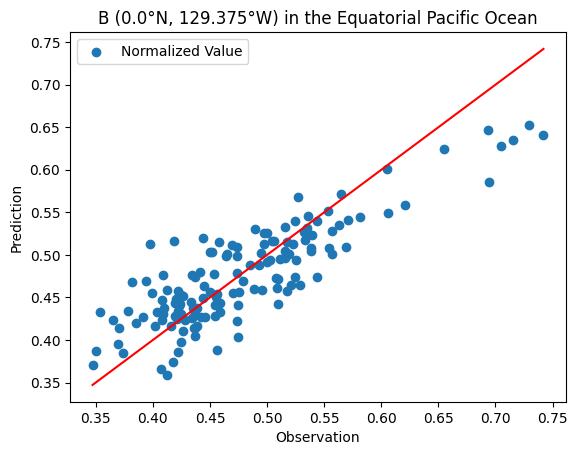

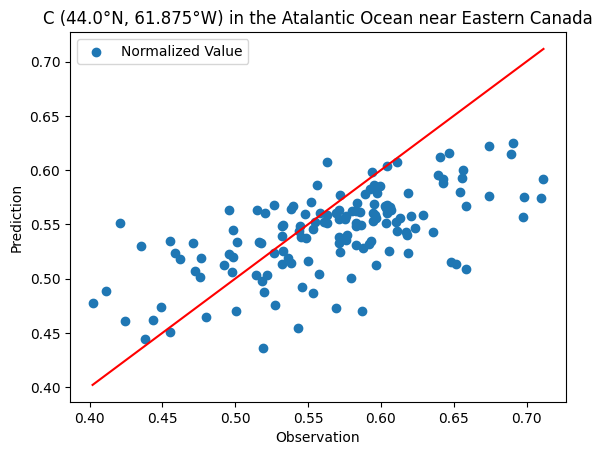

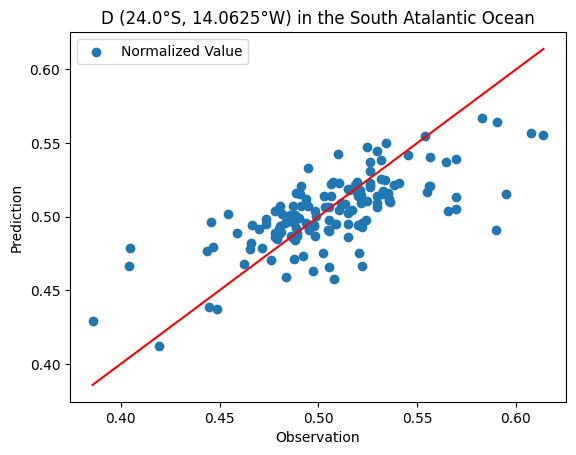

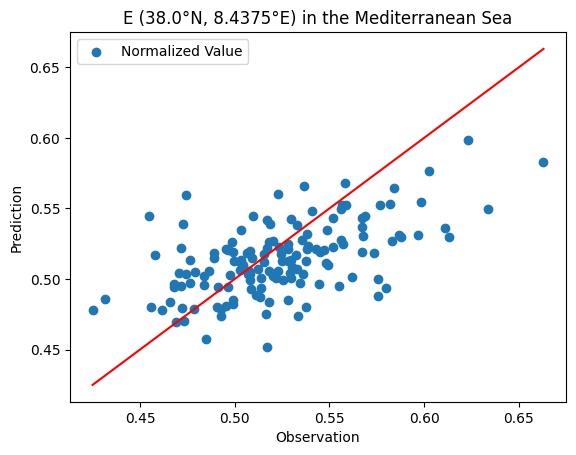

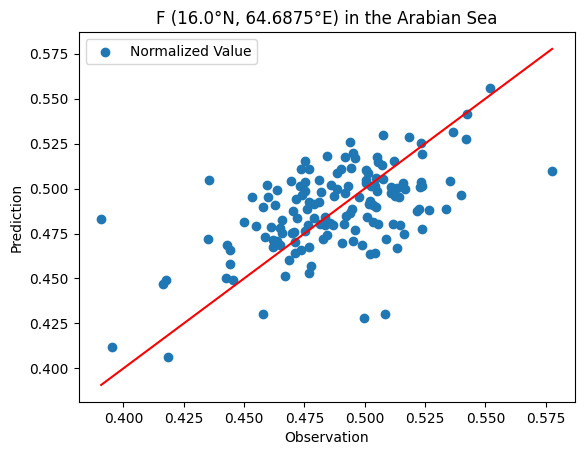

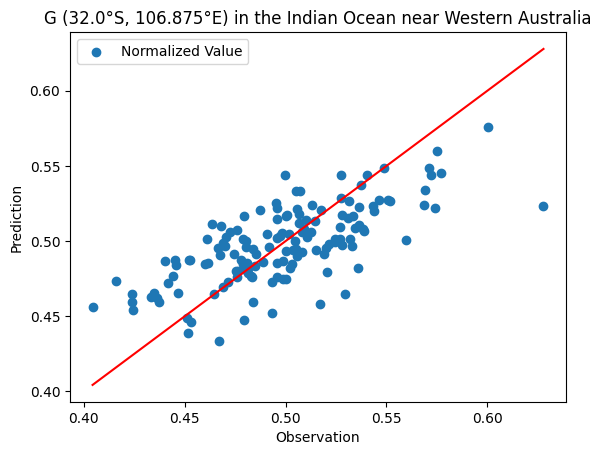

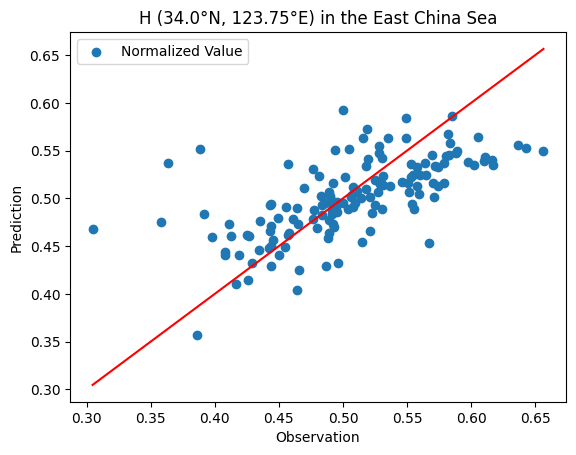

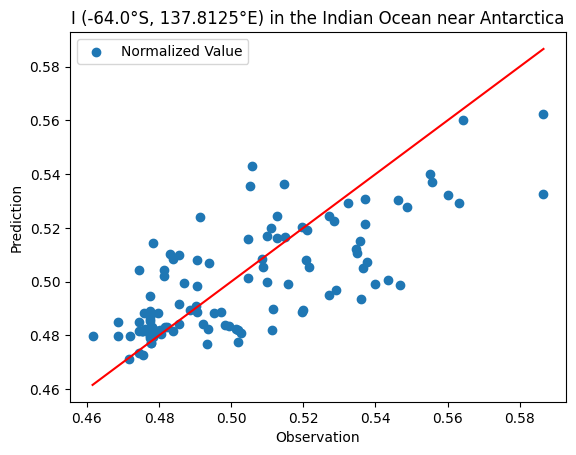

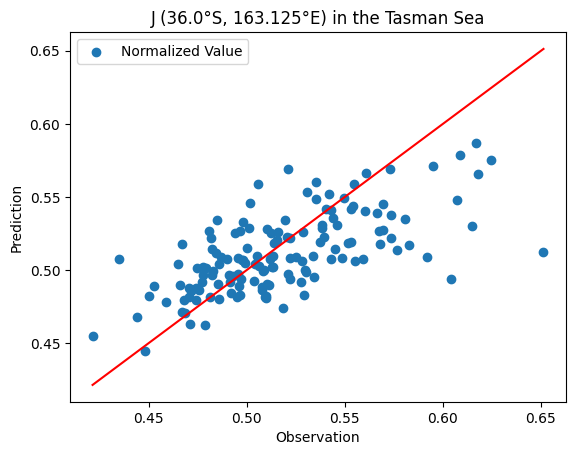

In [86]:
plot_scatter_locs(filepath)